# Airline Efficiency Analysis Using DBSCAN #

#### Introduction ####
This project focuses on clustering airline flight data to uncover meaningful patterns and insights on airline operations, pricing strategies and market segmentation. Using the DBSCAN (Density Based Spatial Clustering of Applications with Noise) algorithm, the project explores how various factors like fare, travel distance, ticket type and other flight characteristics cluster together. DBSCAN is an unsupervised learning algorithm used for clustering tasks.

#### Goal ####  
Airline industry is highly competitive and it is necessary to understand how different flights perform. For e.g., identifying outliers in 'fare' data can help airlines detect pricing errors or potential fraud. The primary goal of this project is to gain insights on fare anomalies, route efficiency & market segmentation.

#### Data Source ####  

This dataset is a a random sample of 2M rows found on Expedia between 2022-04-16 and 2022-10-05, where each row is a purchasable ticket, to/from the following airports: ATL, DFW, DEN, ORD, LAX, CLT, MIA, JFK, EWR, SFO, DTW, BOS, PHL, LGA, IAD, OAK.

The dataset includes 2M rows and 27 columns

The data was obtained from Kaggle at [Flight Prices 2M](https://www.kaggle.com/datasets/pablodroca/flight-prices-2m)  

Some key features in this dataset are :  


* startingAirport: Three-character IATA airport code for the initial location.  

* destinationAirport: Three-character IATA airport code for the arrival location.  

* travelDuration: The travel duration in hours and minutes.  

* isBasicEconomy: Boolean for whether the ticket is for basic economy.  

* isRefundable: Boolean for whether the ticket is refundable.  

* isNonStop: Boolean for whether the flight is non-stop.  

* totalFare: The price of the ticket (in USD) including taxes and other fees.  

* seatsRemaining: Integer for the number of seats remaining.  

* totalTravelDistance: The total travel distance in miles.

## Step 1 : Loading & Sampling Data ##

We will be randomly selecting 15,000 rows from the 2 million rows as the large dataset can affect the performance and can use up a lot of resources.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_score
import time
import warnings
import seaborn as sns
from collections import Counter
import re
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

In [2]:
itineraries_Df = pd.read_csv("itineraries_random_2M.csv")

In [3]:
itineraries_Df = itineraries_Df.sample(n=15000,random_state=42)
itineraries_Df = itineraries_Df.reset_index(drop=True)

In [4]:
itineraries_Df.head()

,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,...,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,3a915559d50ebeefaea42960d9cf044e,2022-06-25,2022-08-13,EWR,ATL,HA3OX0MQ,PT2H16M,0,False,False,...,1660422360,2022-08-13T16:26:00.000-04:00,ATL,EWR,Delta,DL,Boeing 717,8160,762,coach
1,9e417bfce665e03ce32f97b35fb8b338,2022-06-22,2022-06-27,BOS,OAK,TNR,PT16H13M,0,False,False,...,1656352500||1656389880,2022-06-27T10:55:00.000-07:00||2022-06-27T21:1...,LAS||OAK,BOS||LAS,Spirit Airlines||Spirit Airlines,NK||NK,||AIRBUS INDUSTRIE A320 SHARKLETS,21000||5640,None||None,coach||coach
2,aa410ec5ad9f4d51274dd37fb7a67bc4,2022-06-18,2022-08-02,DEN,DTW,HA0OA0MQ,PT7H45M,0,False,False,...,1659468600||1659482100,2022-08-02T15:30:00.000-04:00||2022-08-02T19:1...,LGA||DTW,DEN||LGA,Delta||Delta,DL||DL,Boeing 737-800||Airbus A320,14400||7800,1621||485,coach||coach
3,813abf44ba72d5d910e5f292221e9912,2022-04-24,2022-05-18,BOS,LGA,NUAZXNN3,PT3H43M,0,False,False,...,1652904540||1652911980,2022-05-18T16:09:00.000-04:00||2022-05-18T18:1...,DCA||LGA,BOS||DCA,American Airlines||American Airlines,AA||AA,Airbus A319||Airbus A319,5940||4380,406||221,coach||coach
4,c919a270a0ac8656459aa97fc896179d,2022-06-04,2022-06-24,BOS,JFK,QAUOA0MQ,PT1H31M,0,False,False,...,1656106200,2022-06-24T17:30:00.000-04:00,JFK,BOS,Delta,DL,Airbus A220-100,5460,185,coach


## Step 1 : Data Cleaning ##

Before we can do EDA or any visualizations on the dataset, it is necessary to perform data cleaning. The cleaning tasks performed in this data set are :  

1. Remove columns that will not be used for the project. This will improve model performance.    

2. Check for duplicates. If duplicates are detected, remove them from dataset  

3. Remove any rows that has na values in any columns  

4. Transform boolean values (True/False) to int (0/1)  

5. Extract month from search date for visualizations  

6. Transform alphanumeric 'TravelDuration' to decimal hours. For e.g. 'PT2H16M' will be transformed to 2.26 hours

#### Remove columns that will not be used for the project  ####

In [5]:
itineraries_Df = itineraries_Df[["searchDate","startingAirport","destinationAirport","travelDuration",
                                 "isBasicEconomy","isRefundable","isNonStop","totalFare","seatsRemaining",
                                 "totalTravelDistance"]]

#### Check for duplicates. If duplicates are detected, remove them from dataset  ####

In [6]:
itineraries_Df.duplicated().sum()

19

In [7]:
dups = itineraries_Df[itineraries_Df.duplicated(keep=False)].sort_values(by=["searchDate","startingAirport","destinationAirport","travelDuration",
                                 "isBasicEconomy","isRefundable","isNonStop","totalFare","seatsRemaining",
                                 "totalTravelDistance"])
print(dups.head(6) )

       searchDate startingAirport destinationAirport travelDuration  \
3294   2022-04-21             DFW                LGA        PT3H29M   
3351   2022-04-21             DFW                LGA        PT3H29M   
3175   2022-04-25             BOS                MIA        PT5H18M   
11536  2022-04-25             BOS                MIA        PT5H18M   
11130  2022-04-29             DTW                LGA        PT1H46M   
12524  2022-04-29             DTW                LGA        PT1H46M   

       isBasicEconomy  isRefundable  isNonStop  totalFare  seatsRemaining  \
3294            False         False       True      143.6               7   
3351            False         False       True      143.6               7   
3175            False         False      False      107.6               7   
11536           False         False      False      107.6               7   
11130           False         False       True      173.6               7   
12524           False         False     

In [8]:
itineraries_Df = itineraries_Df.drop_duplicates(subset=["searchDate","startingAirport","destinationAirport","travelDuration",
                                 "isBasicEconomy","isRefundable","isNonStop","totalFare","seatsRemaining",
                                 "totalTravelDistance"])

#### Remove any rows that has na values in any columns  ####

In [9]:
itineraries_Df.dropna(inplace=True)

#### Transform boolean values (True/False) to int (0/1)  ####

In [10]:
itineraries_Df['isBasicEconomy'] = itineraries_Df['isBasicEconomy'].astype(int)
itineraries_Df['isRefundable'] = itineraries_Df['isRefundable'].astype(int)
itineraries_Df['isNonStop'] = itineraries_Df['isNonStop'].astype(int)

#### Extract Month from search date  #### 

In [11]:
itineraries_Df['searchMonth'] = pd.DatetimeIndex(itineraries_Df['searchDate']).month

#### Transform alphanumeric 'TravelDuration' to decimal hours. For e.g. 'PT2H16M' will be transformed to 2.26 hours ####

In [12]:
def Travel_Duration_to_Hours(duration):
    
    match = re.match(r'P(?:(\d+)D)?T(?:(\d+)H)?(?:(\d+)M)?',duration)
    
    if match:
        groups = match.groups()
        groups = tuple(int(group) if group is not None else 0 for group in groups)
    
        days = groups[0]
        hours = groups[1]
        minutes = groups[2]
    
        decimal_hours = days * 24 + hours + minutes/60.0
        return decimal_hours
    

In [13]:
itineraries_Df['TravelHrs'] = itineraries_Df['travelDuration'].apply(Travel_Duration_to_Hours)

In [14]:
itineraries_Df.head()

,searchDate,startingAirport,destinationAirport,travelDuration,isBasicEconomy,isRefundable,isNonStop,totalFare,seatsRemaining,totalTravelDistance,searchMonth,TravelHrs
0,2022-06-25,EWR,ATL,PT2H16M,0,0,1,373.61,9,762.0,6,2.266667
2,2022-06-18,DEN,DTW,PT7H45M,0,0,0,437.60,9,2106.0,6,7.750000
3,2022-04-24,BOS,LGA,PT3H43M,0,0,0,107.60,7,627.0,4,3.716667
4,2022-06-04,BOS,JFK,PT1H31M,0,0,1,218.60,3,185.0,6,1.516667
5,2022-05-11,ORD,BOS,PT2H20M,0,0,1,102.60,5,862.0,5,2.333333


In [15]:
itineraries_Df.drop(['searchDate', 'travelDuration'],axis='columns',inplace=True)

In [16]:
itineraries_Df.head()

,startingAirport,destinationAirport,isBasicEconomy,isRefundable,isNonStop,totalFare,seatsRemaining,totalTravelDistance,searchMonth,TravelHrs
0,EWR,ATL,0,0,1,373.61,9,762.0,6,2.266667
2,DEN,DTW,0,0,0,437.60,9,2106.0,6,7.750000
3,BOS,LGA,0,0,0,107.60,7,627.0,4,3.716667
4,BOS,JFK,0,0,1,218.60,3,185.0,6,1.516667
5,ORD,BOS,0,0,1,102.60,5,862.0,5,2.333333


## Step 2 : EDA & Visualization ##

### Overview Of The Dataset ###

The dataset info() shows that all values are non null. This also includes the datatype of all columns

In [17]:
itineraries_Df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13893 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   startingAirport      13893 non-null  object 
 1   destinationAirport   13893 non-null  object 
 2   isBasicEconomy       13893 non-null  int64  
 3   isRefundable         13893 non-null  int64  
 4   isNonStop            13893 non-null  int64  
 5   totalFare            13893 non-null  float64
 6   seatsRemaining       13893 non-null  int64  
 7   totalTravelDistance  13893 non-null  float64
 8   searchMonth          13893 non-null  int64  
 9   TravelHrs            13893 non-null  float64
dtypes: float64(3), int64(5), object(2)
memory usage: 1.2+ MB


Below are the mathematical statistics for all numeric fields in the dataset. Below insights obtained from this step:  

* Non of the tickets in the dataset are refundable.  

* Cheapest flight fare was $\$$ 35.97 while the most expensive was \$4752.6.  

* The average number of seats remaining per flight is 6.  

* The shortest distance travelled is 97 miles while the longest was 3958 miles.  

* The dataset contains data only for month April, May & June.  

* The shortest flight was 0.76 hrs or 45 minutes and the longest flight was 23.61 hours or almost 1 full day.

In [18]:
itineraries_Df.describe()

,isBasicEconomy,isRefundable,isNonStop,totalFare,seatsRemaining,totalTravelDistance,searchMonth,TravelHrs
count,13893.000000,13893.0,13893.000000,13893.000000,13893.000000,13893.000000,13893.00000,13893.000000
mean,0.051969,0.0,0.307133,394.190369,6.019506,1559.295185,5.15605,6.732304
std,0.221972,0.0,0.461322,216.066393,2.651672,839.217823,0.76112,3.588387
min,0.000000,0.0,0.000000,35.970000,1.000000,97.000000,4.00000,0.766667
25%,0.000000,0.0,0.000000,236.600000,4.000000,862.000000,5.00000,3.933333
50%,0.000000,0.0,0.000000,367.600000,7.000000,1392.000000,5.00000,6.416667
75%,0.000000,0.0,1.000000,513.600000,9.000000,2349.000000,6.00000,9.016667
max,1.000000,0.0,1.000000,4752.600000,10.000000,3958.000000,6.00000,23.616667


In [19]:
itineraries_Df.nunique()

startingAirport          16
destinationAirport       16
isBasicEconomy            2
isRefundable              1
isNonStop                 2
totalFare              3435
seatsRemaining           10
totalTravelDistance    1284
searchMonth               3
TravelHrs               976
dtype: int64

After cleaning, the dataset includes 13893 rows and 10 columns

In [20]:
itineraries_Df.shape

(13893, 10)

### Correlation Analysis ###

From the correlation matrix we can observe that :  

* **Travel hours & total travel distance** are strongly and positively correlated as expected (0.7)  

* **IsNonStop & Travel hours** are strongly and negatively correlated (-0.69), meaning non-stop flights tend to have shorter travel hours. This could be because they do not have layovers.  

* **Total fare & total travel distance** are moderately & positively correlated (0.6), meaning longer flights generally tend to be more expensive  

/var/folders/02/frstdddj7197lw992h6kz0v80000gn/T/ipykernel_15628/118227699.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(itineraries_Df.corr(),annot=True,cmap='coolwarm')


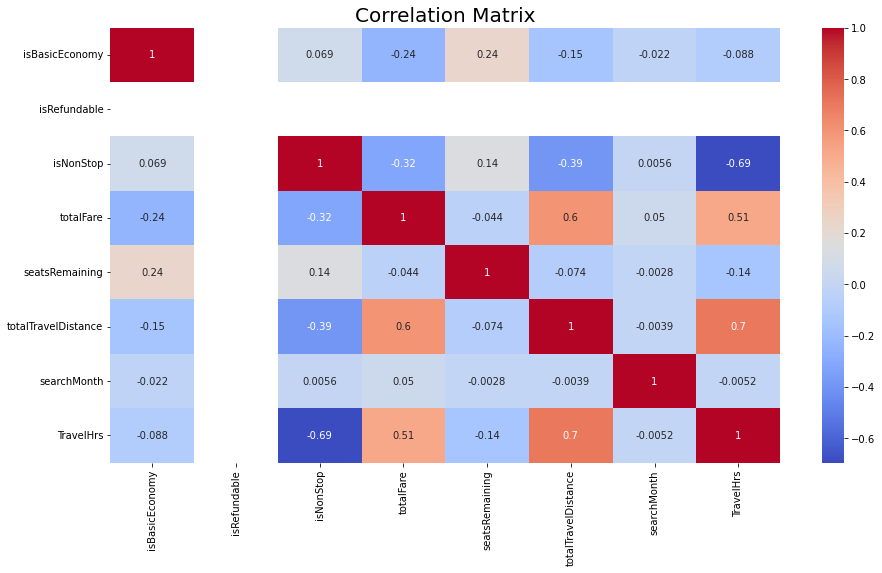

In [21]:
plt.figure(figsize=(15,8))
sns.heatmap(itineraries_Df.corr(),annot=True,cmap='coolwarm')
plt.title('Correlation Matrix', fontsize=20)
plt.show()

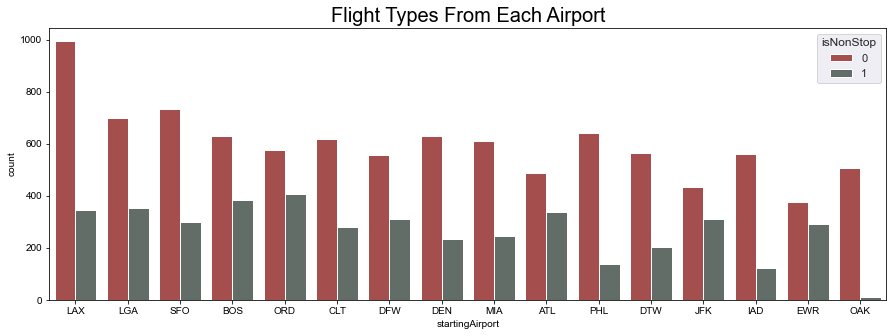

In [22]:
sns.set_palette("dark")
plt.figure(figsize=(15,5))
width = 35
height = 5
plt.title('Flight Types From Each Airport',fontsize=20)
sns.set(rc={'figure.figsize':(width,height)})
sns.countplot(itineraries_Df,x="startingAirport",hue="isNonStop",order= itineraries_Df['startingAirport']
              .value_counts().index,palette=['#B43F3F','#5F6F65'])
plt.show()

/var/folders/02/frstdddj7197lw992h6kz0v80000gn/T/ipykernel_15628/2121822592.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(itineraries_Df,x="searchMonth",palette=['#B43F3F','#5F6F65','#134B70'])


<AxesSubplot:title={'center':'Flight Searches Per Month'}, xlabel='searchMonth', ylabel='count'>

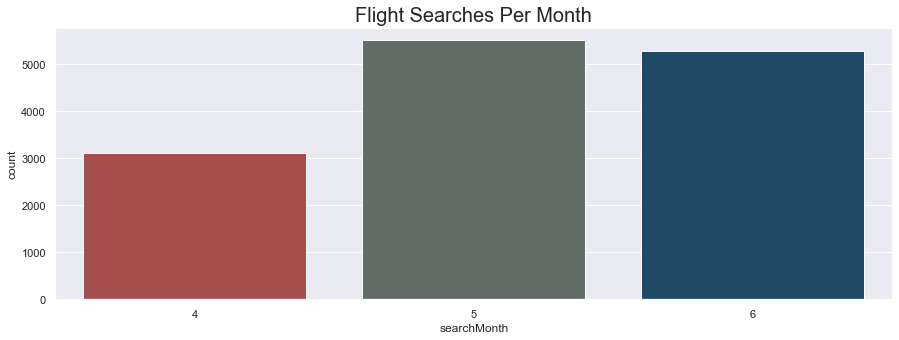

In [23]:
plt.figure(figsize=(15,5))
width = 35
height = 5
plt.title('Flight Searches Per Month',fontsize=20)
sns.set(rc={'figure.figsize':(width,height)})

sns.countplot(itineraries_Df,x="searchMonth",palette=['#B43F3F','#5F6F65','#134B70'])

### Distribution of Features ###

<Figure size 1080x1440 with 0 Axes>

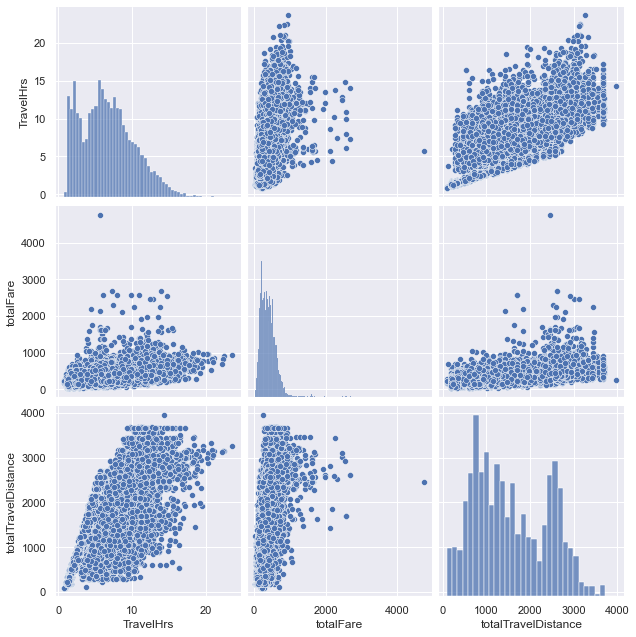

In [24]:
pair_plot_df = itineraries_Df[["TravelHrs","totalFare", "totalTravelDistance"]]
plt.figure(figsize=(15,20))
sns.pairplot(pair_plot_df, height=3)
plt.show()

## Step 3 Model Building With Hyperparameter Tuning & Feature Engineering ##

Features in the dataset can have different ranges. As observed before during EDA, total fare can range from 30s to 4000s. If these features are used as is, those with larger ranges can disproportionately influence the results. Scaling ensures that each feature contributes equally to the distance calculations.

In [67]:
def Normalize_Features(df):
    features = ['totalFare','totalTravelDistance','TravelHrs']
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df[features])
    return df_scaled

In [68]:
df_scaled = Normalize_Features(itineraries_Df)

During the hyperparameter tuning phase of the project, a k-distance graph was used to find optimal epsilon for DBSCAN.

In [69]:
def optimal_epsilon(data,k=4):
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(data)
    dist,indices = neighbors_fit.kneighbors(data)
    dist = np.sort(dist[:,k-1],axis=0)
    
    knee = KneeLocator(range(len(dist)), dist,curve='convex',direction='increasing')
    elbow_point = knee.elbow
    elbow_dist = dist[elbow_point] if elbow_point is not None else None
    
    plt.figure(figsize=(15,4))
    plt.plot(dist)
    plt.axvline(x=elbow_point,color='r',linestyle='--',label = f'Elbow at {elbow_point}')
    plt.title("K - Distance Graph")
    plt.xlabel('Data points by distance')
    plt.ylabel(f'{k}th Nearest Neighbor Distance')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    print("Elbow at index : ",elbow_point)
    print("Distance : ",elbow_dist)
    
    return elbow_dist

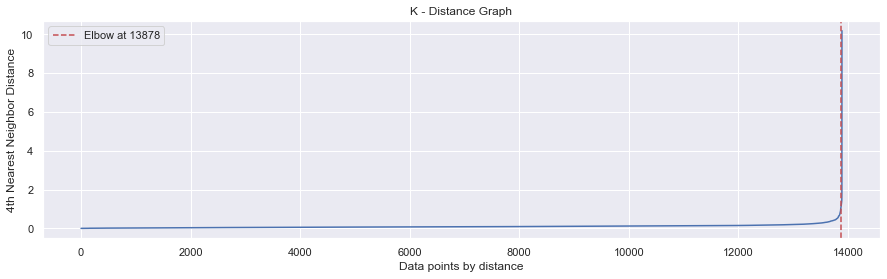

Elbow at index :  13878
Distance :  1.1675452015474093


In [70]:
optimal_distances = optimal_epsilon(df_scaled,k=4)

Model built using DBSCAN with epsilon = 1.1675452015474093 & Min_Sample = 4. We can adjust the value of min_sample if necessary.

In [71]:
dbscan = DBSCAN(eps=optimal_distances,min_samples=4)
itineraries_Df['Cluster'] = dbscan.fit_predict(df_scaled)

## Step 4 : Model Results & Evaluation ##

Below are the clustering results

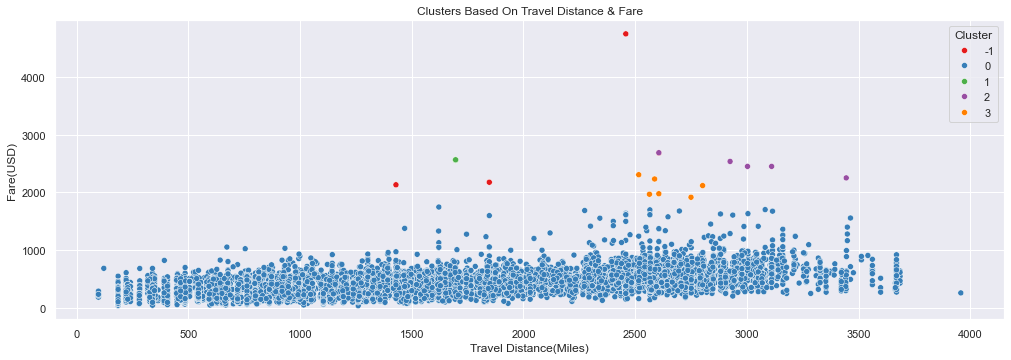

In [72]:
plt.figure(figsize=(17,5.5))
sns.scatterplot(x=itineraries_Df['totalTravelDistance'],y=itineraries_Df['totalFare']
                ,hue=itineraries_Df['Cluster'], palette='Set1')
plt.title('Clusters Based On Travel Distance & Fare')
plt.xlabel('Travel Distance(Miles)')
plt.ylabel('Fare(USD)')
plt.show()

The Silhouette Coefficient is calculated using the mean intra-cluster distance and the mean nearest-cluster distance for each sample. The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar  

The observed Silhouette Score of ~ 0.73 indicates good similarity between points in the same cluster.

In [75]:
score = silhouette_score(df_scaled,itineraries_Df['Cluster'])
print("Silhouette Score = ",score)

Silhouette Score =  0.7313475131533436


In [76]:
print(itineraries_Df['Cluster'].value_counts())

 0    13874
 3        6
 2        5
-1        4
 1        4
Name: Cluster, dtype: int64


## Step 5 : Model Insights & Analysis ##

### 1. Fare Anomalies (Outlier Detection) ###

Points labeled -1 by DBSCAN are considered outliers. These could represent unusual or error data points such as abnormally high fare for a short flight or vice versa. Further investigation is necessary to uncover reasons for such outliers.

In [81]:
def fare_anomalies(df):
    outliers = df[df['Cluster']== -1]
    
    print(f"Number of outliers detected : {len(outliers)}")
    print(outliers[['totalFare','totalTravelDistance','isBasicEconomy','isRefundable']].head())
    
    plt.figure(figsize=(15,7))
    plt.scatter(df['totalTravelDistance'],df['totalFare'],c=df['Cluster'],
               cmap='viridis',alpha=0.6)
    
    plt.scatter(outliers['totalTravelDistance'],outliers['totalFare'],c='red',label = 'Outliers')
    plt.title('Fare v/s Travel Distance with Outliers Highlighted', fontsize=20)
    plt.xlabel('Travel Distance(Miles)')
    plt.ylabel('Fare(USD)')
    plt.legend()
    plt.show()

Number of outliers detected : 4
      totalFare  totalTravelDistance  isBasicEconomy  isRefundable
517      2684.6               2606.0               0             0
3079     4752.6               2458.0               0             0
5535     2133.6               1429.0               0             0
7279     2177.6               1847.0               0             0


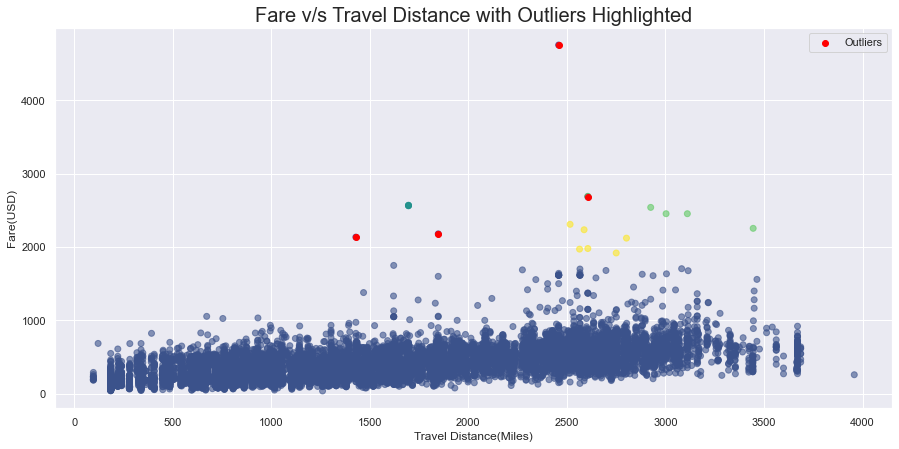

In [82]:
fare_anomalies(itineraries_Df)

### 2. Route Efficiency ###

By clustering flights based on travel distance and fare, we can identify patterns of efficiency. For e.g., one cluster could represent long-haul flights with relatively low fares, suggesting a competitive pricing strategy. Another cluster could represent short flights with high fares, indicating inefficiencies or price gouging.

In [85]:
def route_efficiency(df):
    cluster_summary = df.groupby('Cluster')[['totalFare','totalTravelDistance']].mean().reset_index()
    
    plt.figure(figsize=(15,7))
    sns.scatterplot(x='totalTravelDistance',y='totalFare', hue='Cluster',data=cluster_summary, palette='colorblind')
    plt.title('Route Efficiency : Avg Fare v/s Travel Distance By Cluster', fontsize=20)
    plt.xlabel('Avg. Travel Distance(Miles)')
    plt.ylabel('Avg. Fare(USD)')
    plt.show()
    
    print("Cluster Summary \n",cluster_summary)

Below gives a visualization of how fares vary with travel distance for different clusters

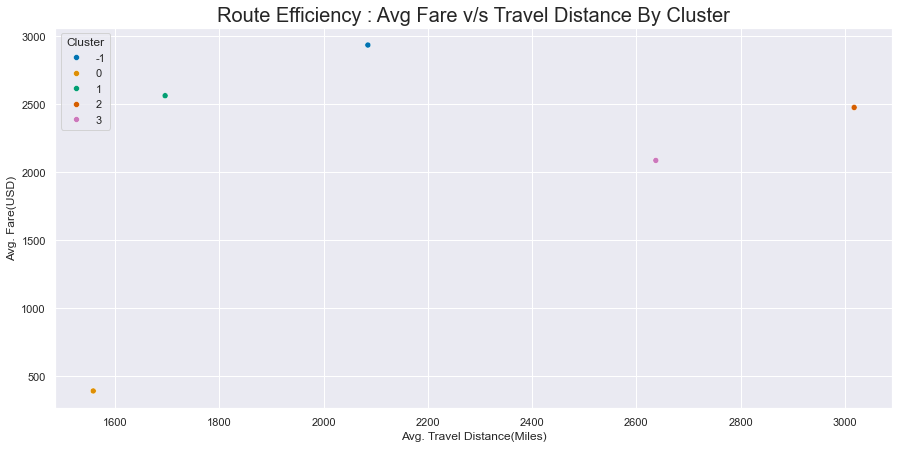

Cluster Summary 
    Cluster    totalFare  totalTravelDistance
0       -1  2937.100000          2085.000000
1        0   391.348313          1558.112224
2        1  2564.400000          1696.000000
3        2  2477.500000          3018.000000
4        3  2087.800000          2637.500000


In [86]:
route_efficiency(itineraries_Df)

### 3. Market Segmentation Based on Ticket Type ###

The below visualization explores segmentation of clusters based on percent of basic economy and non stop flights, helping to understand different market segments.

In [87]:
def Market_Seg(df):
    cluster_segment = df.groupby('Cluster')[['isBasicEconomy','isNonStop']].mean().reset_index()
    
    fig, ax = plt.subplots(1,2,figsize=(15,7))
    sns.barplot(x='Cluster',y='isBasicEconomy',data=cluster_segment,ax=ax[0],palette='colorblind')
    ax[0].set_title('% of Basic Economy Tickets By Cluster')
    ax[0].set_ylabel('% of Basic Economy')
    ax[0].set_xlabel('Cluster')
    
    sns.barplot(x='Cluster', y='isNonStop',data=cluster_segment,ax=ax[1],palette='colorblind')
    ax[1].set_title('% of NonStop Tickets By Cluster')
    ax[1].set_ylabel('% of NonStop')
    ax[1].set_xlabel('Cluster')
    
    plt.tight_layout()
    plt.show()
    
    print("Cluster Segments \n",cluster_segment)

/var/folders/02/frstdddj7197lw992h6kz0v80000gn/T/ipykernel_12525/2445480282.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster',y='isBasicEconomy',data=cluster_segment,ax=ax[0],palette='colorblind')
/var/folders/02/frstdddj7197lw992h6kz0v80000gn/T/ipykernel_12525/2445480282.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y='isNonStop',data=cluster_segment,ax=ax[1],palette='colorblind')


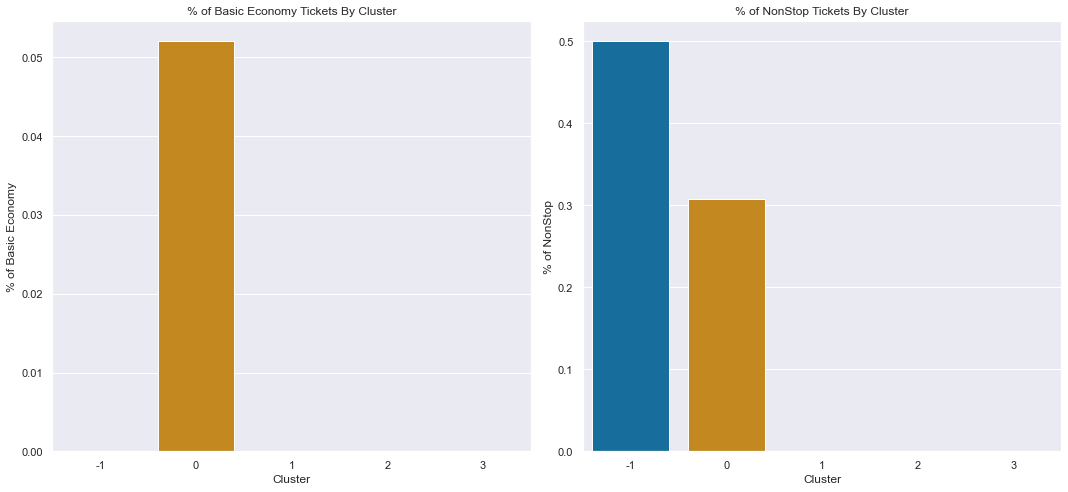

Cluster Segments 
    Cluster  isBasicEconomy  isNonStop
0       -1         0.00000    0.50000
1        0         0.05204    0.30741
2        1         0.00000    0.00000
3        2         0.00000    0.00000
4        3         0.00000    0.00000


In [88]:
Market_Seg(itineraries_Df)

## Conclusion ##

The project successfully demonstrated the application of DBSCAN clustering for airline data, revealing valuable insights into fare anomalies, route efficiency and market segmentation. Through this analysis, I learned how clustering can uncover hidden patterns in the data that are not immediately visible through traditional methods.  
  
The presence of overlapping points in clustering indicate some limitations of DBSCAN, especially in handling complex, high dimensional data. The occurence of outliers (cluster -1) shows that epsilon & min_samples could be optimized further.  
  
#### Improvement Ideas ####

1. Further parameter tuning of epsilon & min_samples 
2. Alternate clustering methods like HDBSCAN, which is more robust to varying densities.  
3. Additional feature engineering such as aggregating data differently could help in forming more distinct clusters.
